<a href="https://colab.research.google.com/github/panjiram/Program-Tugas-Akhir/blob/main/TA_Klasifikasi_Sentimen_metode_SVM_LINEAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **KLASIFIKASI SENTIMEN TWEET TERHADAP KEBIJAKAN KEMENDIKBUD MENGENAI PEMBELAJARAN TATAP MUKA DENGAN METODE SUPPORT VECTOR MACHINE (SVM)**

---

Dataset yang digunakan dalam program ini bisa diunduh melalui link: https://docs.google.com/spreadsheets/d/1Ir2VUG0yI1mSwEpwG3CKk4l8iRKrl4Tm/edit#gid=857898240, yang berisi data postingan yang memberikan sentimen terhadap kebijakan pemerintah tentang PTM di era Covid-19 dengan 2 label (positif & negatif)

## Install sastrawi

In [ ]:
!pip install sastrawi

     |████████████████████████████████| 209 kB 13.1 MB/s 


In [ ]:
!pip install openpyxl==3.0.9

     |████████████████████████████████| 242 kB 14.4 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


## Load library

In [ ]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import itertools
import string
import gensim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')

from datetime import datetime
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import dataset

In [ ]:
df_tweets = pd.read_excel('dataset_ptm.xlsx')

dataset kamus alay karena twitter banyak menggunakan istilah-istilah tidak baku dalam penulisannya

In [ ]:
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',1: 'replacement'})

In [ ]:
df_tweets.isna().sum()

no       0
tweet    0
label    0
dtype: int64

In [ ]:
df_tweets = df_tweets.drop(columns='no')
df_tweets

,tweet,label
0,Alhamdulillah🤗 yang penting akhirnya ga online...,Positif
1,💙Tetap semangat yuk ptmnya,Positif
2,alhamdulillah semenjak ptm tiap hari saldo dom...,Positif
3,"@djuniestt wah sudah ptm, semangat! sekolah di...",Positif
4,tetep lakuin prokes ya temen2 yang Alhamdulila...,Positif
...,...,...
527,"drkmaren gue nunggu berita PTM ditutup lagi, g...",Negatif
528,"bener bener dah ptm pusing bgt maaf. stres, br...",Negatif
529,kayaknya 98% anak sekolahan yg ptm badannya ad...,Negatif
530,"@schfess gara² ptm, aku nyicil materi jadi kur...",Negatif


## Preprocessing Function


In [ ]:
sw = stopwords.words('indonesian')

In [ ]:
factory = StopWordRemoverFactory()
 
def remove_tweet_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"").replace('USERNAME', "").replace('-', " ").replace(',', " ")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text.replace("http://", " ").replace("https://", " ")
                
def remove_number(text):
    return  re.sub(r"\d+", "", text)
 
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
 
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)
    
def remove_whitespace_LT(text):
    return text.strip()
    
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)
 
def word_tokenize_wrapper(text):
    return word_tokenize(text)
 
def preprocess_tweet(tweet):
    tweet.lower()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output = stemmer.stem(tweet) 
    return output
  
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

In [ ]:
print(sw)

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan'

## Text Preprocessing

In [ ]:
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_tweet_special)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_number)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_punctuation)
df_tweets['tweet'] = df_tweets['tweet'].apply(normalize_alay)
df_tweets['tweet'] = df_tweets['tweet'].apply(stopwords)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_LT)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_multiple)

In [ ]:
df_tweets

,tweet,label
0,alhamdulillah online ptm bersyukur banget,Positif
1,semangat yuk ptmnya,Positif
2,alhamdulillah semenjak ptm saldo dompet mengal...,Positif
3,ptm semangat sekolah asyik pokoknya hehe,Positif
4,lakukan prokes ya teman alhamdulilah ptm full ...,Positif
...,...,...
527,drkmaren gue menunggu berita ptm ditutup gue c...,Negatif
528,ptm pusing banget maaf stres breakout nafsu ma...,Negatif
529,kayaknya anak sekolahan ptm badannya sakit sak...,Negatif
530,gara ptm mencicil materi pintar mengatur sih n...,Negatif


## Stemming data tweet dengan library Sastrawi

Untuk menghemat waktu dalam proses stemming data menggunakan sastrawi, maka saya export kedalam format xlsx untuk digunakan dikemudian hari tanpa harus melakukan stemming kembali

In [ ]:
df_tweets['tweet_norm'] = df_tweets['tweet'].apply(preprocess_tweet)
df_tweets.to_excel('tweets_preprocessed.xlsx')

## Load preprocessed data tweet

In [ ]:
df_tweets = pd.read_excel('tweets_preprocessed.xlsx')
df_tweets.drop(columns={'Unnamed: 0'}, axis=1, inplace=True)

In [ ]:
df_tweets

,tweet,label,tweet_norm
0,alhamdulillah online ptm bersyukur banget,Positif,alhamdulillah online ptm syukur banget
1,semangat yuk ptmnya,Positif,semangat yuk ptmnya
2,alhamdulillah semenjak ptm saldo dompet mengal...,Positif,alhamdulillah semenjak ptm saldo dompet alami ...
3,ptm semangat sekolah asyik pokoknya hehe,Positif,ptm semangat sekolah asyik pokok hehe
4,lakukan prokes ya teman alhamdulilah ptm full ...,Positif,laku prokes ya teman alhamdulilah ptm full sta...
...,...,...,...
527,drkmaren gue menunggu berita ptm ditutup gue c...,Negatif,drkmaren gue tunggu berita ptm tutup gue cape ...
528,ptm pusing banget maaf stres breakout nafsu ma...,Negatif,ptm pusing banget maaf stres breakout nafsu ma...
529,kayaknya anak sekolahan ptm badannya sakit sak...,Negatif,kayak anak sekolah ptm badan sakit sakit sih m...
530,gara ptm mencicil materi pintar mengatur sih n...,Negatif,gara ptm cicil materi pintar atur sih nder ner...


## Create freqDist_wrapper to counting frequency from each word

In [ ]:
def freqDist_wrapper(text):
    return FreqDist(text)

df_tweets['tweet_tokens'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)

df_tweets['tweet_tokens_fdist'] = df_tweets['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(df_tweets['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(alhamdulillah, 1), (online, 1), (ptm, 1), (s...
1               [(semangat, 1), (yuk, 1), (ptmnya, 1)]
2    [(alhamdulillah, 1), (semenjak, 1), (ptm, 1), ...
3    [(ptm, 1), (semangat, 1), (sekolah, 1), (asyik...
4    [(laku, 1), (prokes, 1), (ya, 1), (teman, 1), ...
Name: tweet_tokens_fdist, dtype: object


## Create Clean_length function & convert_to_string
Bertujuan untuk menghapus kata yang kurang dari 3 karakter

In [ ]:
def Clean_length(token):
    return [i for i in token if len(i) > 3]
def convert_to_string(listReview):
    return ' '.join(listReview)

df_tweets['tweet_norm2'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(Clean_length)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(convert_to_string)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(stopwords)

## Result of preprocessed data tweet
* **label** -> Positif / Negatif
* **tweet** -> alhamdulillah setelah PTM saldo dompet mengalami peningkatan
* **tweet_norm** -> kata yang sudah di normalisasi/preprocess
* **tweet_tokens** -> memisahkan setiap kata kemudian diubah menjadi list sebagai processing text nanti
* **tweet_tokens_fdist** -> mencari frekuensi dari setiap kata
* **tweet_norm2** -> Kata-kata yang sudah tidak memiliki kata kurang dari 4 karakter
* **label_id** -> Label yang sudah diubah menjadi numerical



In [ ]:
df_tweets

,tweet,label,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2
0,alhamdulillah online ptm bersyukur banget,Positif,alhamdulillah online ptm syukur banget,"[alhamdulillah, online, ptm, syukur, banget]","{'alhamdulillah': 1, 'online': 1, 'ptm': 1, 's...",alhamdulillah online syukur banget
1,semangat yuk ptmnya,Positif,semangat yuk ptmnya,"[semangat, yuk, ptmnya]","{'semangat': 1, 'yuk': 1, 'ptmnya': 1}",semangat ptmnya
2,alhamdulillah semenjak ptm saldo dompet mengal...,Positif,alhamdulillah semenjak ptm saldo dompet alami ...,"[alhamdulillah, semenjak, ptm, saldo, dompet, ...","{'alhamdulillah': 1, 'semenjak': 1, 'ptm': 1, ...",alhamdulillah semenjak saldo dompet alami tingkat
3,ptm semangat sekolah asyik pokoknya hehe,Positif,ptm semangat sekolah asyik pokok hehe,"[ptm, semangat, sekolah, asyik, pokok, hehe]","{'ptm': 1, 'semangat': 1, 'sekolah': 1, 'asyik...",semangat sekolah asyik pokok hehe
4,lakukan prokes ya teman alhamdulilah ptm full ...,Positif,laku prokes ya teman alhamdulilah ptm full sta...,"[laku, prokes, ya, teman, alhamdulilah, ptm, f...","{'laku': 1, 'prokes': 1, 'ya': 1, 'teman': 1, ...",laku prokes teman alhamdulilah full stay aman
...,...,...,...,...,...,...
527,drkmaren gue menunggu berita ptm ditutup gue c...,Negatif,drkmaren gue tunggu berita ptm tutup gue cape ...,"[drkmaren, gue, tunggu, berita, ptm, tutup, gu...","{'drkmaren': 1, 'gue': 2, 'tunggu': 1, 'berita...",drkmaren tunggu berita tutup cape banget anjir...
528,ptm pusing banget maaf stres breakout nafsu ma...,Negatif,ptm pusing banget maaf stres breakout nafsu ma...,"[ptm, pusing, banget, maaf, stres, breakout, n...","{'ptm': 1, 'pusing': 1, 'banget': 1, 'maaf': 1...",pusing banget maaf stres breakout nafsu makan ...
529,kayaknya anak sekolahan ptm badannya sakit sak...,Negatif,kayak anak sekolah ptm badan sakit sakit sih m...,"[kayak, anak, sekolah, ptm, badan, sakit, saki...","{'kayak': 1, 'anak': 1, 'sekolah': 1, 'ptm': 1...",kayak anak sekolah badan sakit sakit mudah cape
530,gara ptm mencicil materi pintar mengatur sih n...,Negatif,gara ptm cicil materi pintar atur sih nder ner...,"[gara, ptm, cicil, materi, pintar, atur, sih, ...","{'gara': 1, 'ptm': 1, 'cicil': 1, 'materi': 1,...",gara cicil materi pintar atur nder nerapin


## Count unique words in data tweet

In [ ]:
unique_string = set()
for x in df_tweets['tweet_norm2']:
    for y in x.split():
        unique_string.add(y)
        
len(unique_string)

880

In [ ]:
unique_string

{'aaaa',
 'aaaaaa',
 'aaahhh',
 'aamiiiin',
 'abiessssssssss',
 'abrek',
 'absen',
 'adalahuang',
 'adapatasi',
 'adaptasi',
 'adek',
 'adik',
 'aduh',
 'ahagha',
 'aidan',
 'ajak',
 'ajang',
 'ajar',
 'ajsjsk',
 'akdjakdjksjdjs',
 'aktif',
 'aktivitas',
 'akwowowk',
 'alah',
 'alam',
 'alami',
 'alas',
 'alat',
 'alhamdulilah',
 'alhamdulillah',
 'alias',
 'allah',
 'allhamdulillah',
 'alquran',
 'aman',
 'ambil',
 'amin',
 'anak',
 'ancam',
 'aneh',
 'angan',
 'anggapgw',
 'angin',
 'angkat',
 'anjerr',
 'anjing',
 'anjinggg',
 'anjinggggg',
 'anjir',
 'anjlok',
 'anjrit',
 'anjrittt',
 'anjrr',
 'anjrt',
 'anjuuu',
 'anto',
 'antre',
 'antuk',
 'antusias',
 'argh',
 'army',
 'ashanty',
 'asiknya',
 'asli',
 'astaga',
 'astagfirullah',
 'astaghfirullah',
 'asyik',
 'atur',
 'aware',
 'babi',
 'baca',
 'bacot',
 'badan',
 'bagus',
 'bahagia',
 'bahasa',
 'baju',
 'balap',
 'bang',
 'banget',
 'bangsat',
 'bangun',
 'banya',
 'bapa',
 'bareng',
 'baruuuueyyeyyayyeuay',
 'batal',
 'bata

## Change label into number

In [ ]:
df_tweets['label_id'] = df_tweets['label'].map({"Positif": 1, "Negatif": 0})
from io import StringIO
kategori_id_data = df_tweets[['label', 'label_id']].drop_duplicates().sort_values('label_id', ascending=False)
kategori_to_id = dict(kategori_id_data.values)
id_to_kategori = dict(kategori_id_data[['label_id', 'label']].values)
df_tweets

,tweet,label,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2,label_id
0,alhamdulillah online ptm bersyukur banget,Positif,alhamdulillah online ptm syukur banget,"[alhamdulillah, online, ptm, syukur, banget]","{'alhamdulillah': 1, 'online': 1, 'ptm': 1, 's...",alhamdulillah online syukur banget,1
1,semangat yuk ptmnya,Positif,semangat yuk ptmnya,"[semangat, yuk, ptmnya]","{'semangat': 1, 'yuk': 1, 'ptmnya': 1}",semangat ptmnya,1
2,alhamdulillah semenjak ptm saldo dompet mengal...,Positif,alhamdulillah semenjak ptm saldo dompet alami ...,"[alhamdulillah, semenjak, ptm, saldo, dompet, ...","{'alhamdulillah': 1, 'semenjak': 1, 'ptm': 1, ...",alhamdulillah semenjak saldo dompet alami tingkat,1
3,ptm semangat sekolah asyik pokoknya hehe,Positif,ptm semangat sekolah asyik pokok hehe,"[ptm, semangat, sekolah, asyik, pokok, hehe]","{'ptm': 1, 'semangat': 1, 'sekolah': 1, 'asyik...",semangat sekolah asyik pokok hehe,1
4,lakukan prokes ya teman alhamdulilah ptm full ...,Positif,laku prokes ya teman alhamdulilah ptm full sta...,"[laku, prokes, ya, teman, alhamdulilah, ptm, f...","{'laku': 1, 'prokes': 1, 'ya': 1, 'teman': 1, ...",laku prokes teman alhamdulilah full stay aman,1
...,...,...,...,...,...,...,...
527,drkmaren gue menunggu berita ptm ditutup gue c...,Negatif,drkmaren gue tunggu berita ptm tutup gue cape ...,"[drkmaren, gue, tunggu, berita, ptm, tutup, gu...","{'drkmaren': 1, 'gue': 2, 'tunggu': 1, 'berita...",drkmaren tunggu berita tutup cape banget anjir...,0
528,ptm pusing banget maaf stres breakout nafsu ma...,Negatif,ptm pusing banget maaf stres breakout nafsu ma...,"[ptm, pusing, banget, maaf, stres, breakout, n...","{'ptm': 1, 'pusing': 1, 'banget': 1, 'maaf': 1...",pusing banget maaf stres breakout nafsu makan ...,0
529,kayaknya anak sekolahan ptm badannya sakit sak...,Negatif,kayak anak sekolah ptm badan sakit sakit sih m...,"[kayak, anak, sekolah, ptm, badan, sakit, saki...","{'kayak': 1, 'anak': 1, 'sekolah': 1, 'ptm': 1...",kayak anak sekolah badan sakit sakit mudah cape,0
530,gara ptm mencicil materi pintar mengatur sih n...,Negatif,gara ptm cicil materi pintar atur sih nder ner...,"[gara, ptm, cicil, materi, pintar, atur, sih, ...","{'gara': 1, 'ptm': 1, 'cicil': 1, 'materi': 1,...",gara cicil materi pintar atur nder nerapin,0


In [ ]:
preprocessed=[]
for i in df_tweets['tweet_norm2']:
  preprocessed.append({"tweet": i})
pd.set_option('display.max_colwidth', 1)
pd.DataFrame(preprocessed)

,tweet
0,alhamdulillah online syukur banget
1,semangat ptmnya
2,alhamdulillah semenjak saldo dompet alami tingkat
3,semangat sekolah asyik pokok hehe
4,laku prokes teman alhamdulilah full stay aman
...,...
527,drkmaren tunggu berita tutup cape banget anjir sekolah offline kayak rumah
528,pusing banget maaf stres breakout nafsu makan tidur doang huhu
529,kayak anak sekolah badan sakit sakit mudah cape
530,gara cicil materi pintar atur nder nerapin


In [ ]:
df_tweets['tweet_norm2'].to_excel('norm2.xlsx')

## Create variable y_new as array label and check the balance of data tweet

In [ ]:
y_list = list(df_tweets['label'])
y_new = np.array(y_list)

Positif    266
Negatif    266
Name: label, dtype: int64

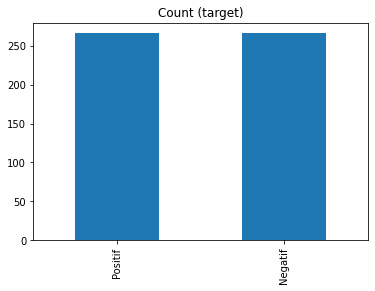

In [ ]:
target_count = df_tweets['label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
target_count

In [ ]:
X = df_tweets['tweet'].values
y = df_tweets['label'].values

## TF-IDF & Word Visualization

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
Train_X_Tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X_train_counts.shape

(532, 1175)

In [ ]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=8)
token_vocab = df_tweets['tweet_norm2'].apply(word_tokenize_wrapper)
matrix = vectorizer.fit_transform([x for x in np.array(token_vocab)])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 63


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


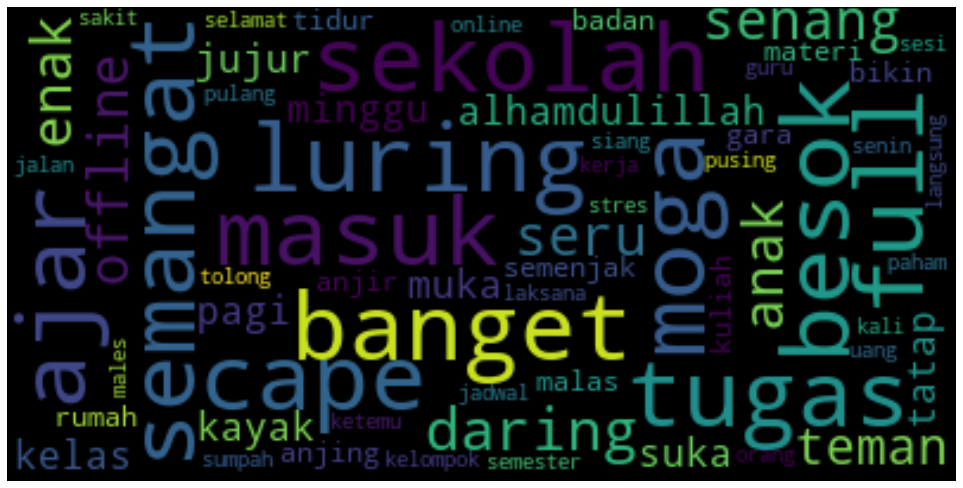

In [ ]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(17, 17))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']    
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True))

## Data splitting for 20% data training & 80% data testing

In [ ]:
train_pct_index = int(0.8 * len(X))
X_train, X_test = Train_X_Tfidf[:train_pct_index], Train_X_Tfidf[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
X_train, X_test, y_train, y_test = train_test_split(Train_X_Tfidf, y, test_size=0.1, random_state= 0)

## Create & fitting model SVM


In [ ]:
start_time = datetime.now()
svm = LinearSVC(C=1, max_iter=1000)
clf = CalibratedClassifierCV(svm)
clf.fit(X_train, y_train)
clftest = svm.fit(X_train, y_train)
y_pred = clftest.predict(X_test)
y_proba = clf.predict_proba(X_test)
end_time = datetime.now()
print("Duration: {}".format(end_time - start_time))

Duration: 0:00:00.032086


## Evaluation


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy %.2f" % (accuracy_score(y_pred, y_test) * 100 ))

[[23  6]
 [ 5 20]]
              precision    recall  f1-score   support

     Negatif       0.82      0.79      0.81        29
     Positif       0.77      0.80      0.78        25

    accuracy                           0.80        54
   macro avg       0.80      0.80      0.80        54
weighted avg       0.80      0.80      0.80        54

Accuracy 79.63


## Prediction

In [ ]:
test =['mari kita berangkat PTM bareng gaesss, semangat!',
       'Gw suka PTM kalo misal pelajaran kimia',
       'yahh, ga bisa rebahan lagi deh sekarang gara-gara PTM',
       'saya semangat ptm',
       'saya mau ptm tapi mager, tapi harus berangkatt',
       'sekolah ga guna',
       'udah gak sabar ketemu temen-temen waktu ptm, soalnya bosen online terus.',
       'ptm asyik ketemu temen baru ditambah dompet tebel',
       'yahh']

predicted = []
for i in test :
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = clftest.predict(X_coba)
    acc = clf.predict_proba(X_coba)
    probsvc = acc.max(axis=0)
    pd.options.display.float_format = '{:,.2f}%'.format
    procres = acc.tolist()
    test = "".join(str(e) for e in procres)
    result = test.split(",")
    positif = float(result[1].replace("]",""))
    predicted.append({"Tweet": i , "Label" : y_pred[0], "Probabilty Positif" : "{:.2f} %".format(positif*100)})

pd.DataFrame(predicted)

,Tweet,Label,Probabilty Positif
0,"mari kita berangkat PTM bareng gaesss, semangat!",Positif,97.84 %
1,Gw suka PTM kalo misal pelajaran kimia,Positif,66.22 %
2,"yahh, ga bisa rebahan lagi deh sekarang gara-gara PTM",Negatif,7.11 %
3,saya semangat ptm,Positif,99.37 %
4,"saya mau ptm tapi mager, tapi harus berangkatt",Positif,71.85 %
5,sekolah ga guna,Negatif,36.34 %
6,"udah gak sabar ketemu temen-temen waktu ptm, soalnya bosen online terus.",Positif,66.46 %
7,ptm asyik ketemu temen baru ditambah dompet tebel,Positif,97.24 %
8,yahh,Negatif,43.45 %
